In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil
import umap

# Own libraries
import sys
sys.path.append('/media/adalberto/Disk2/PhD_Workspace')
from data_manipulation.data import Data
from data_manipulation.utils import store_data
from models.evaluation.folds import load_existing_split
from models.clustering.data_processing import *


/home/adalberto/.local/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Data to deal with

In [6]:
folds_pickle = '/media/adalberto/Disk2/PhD_Workspace/utilities/files/LUAD/folds_LUAD_Institutions.pkl'

dataset        = 'TCGAFFPE_LUADLUSC_5x_60pc'
meta_field     = 'luad'
rep_key        = 'z_latent'
matching_field = 'slides'
fold_number    = 4
resolution     = 5.0
groupby        = 'leiden_%s' % resolution

h5_complete_path   = '/media/adalberto/Disk2/PhD_Workspace/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival.h5'
h5_additional_path = '/media/adalberto/Disk2/PhD_Workspace/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128/NYU300LUAD_Survival_5x_60pc/h224_w224_n3_zdim128/hdf5_NYU300LUAD_Survival_5x_60pc_he_train_overall_progression_free_surival.h5'
adatas_path        = '/media/adalberto/Disk2/PhD_Workspace/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128/lungsubtype_nn250/adatas'
adata_name         = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

indexes_remove_path = '/media/adalberto/Disk2/PhD_Workspace/utilities/files/indexes_to_remove'
data_remove_path    = os.path.join(indexes_remove_path, dataset)
if not os.path.isdir(data_remove_path):
    os.makedirs(data_remove_path)


### Dataset Images

In [7]:
data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path='/media/adalberto/Disk2/PhD_Workspace', load=True)

Train Set: /media/adalberto/Disk2/PhD_Workspace/datasets/TCGAFFPE_LUADLUSC_5x_60pc/he/patches_h224_w224/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_train.h5
Validation Set: /media/adalberto/Disk2/PhD_Workspace/datasets/TCGAFFPE_LUADLUSC_5x_60pc/he/patches_h224_w224/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_validation.h5
Test Set: /media/adalberto/Disk2/PhD_Workspace/datasets/TCGAFFPE_LUADLUSC_5x_60pc/he/patches_h224_w224/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_test.h5



### Folds

### Representations, fold, and set frames.

In [62]:
complete_frame,   complete_dims,   complete_rest   = representations_to_frame(h5_complete_path,   meta_field=meta_field, rep_key=rep_key, check_meta=True)
additional_frame, additional_dims, additional_rest = representations_to_frame(h5_additional_path, meta_field=meta_field, rep_key=rep_key)

Loading representations: /media/adalberto/Disk2/PhD_Workspace/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival.h5
Loading representations: /media/adalberto/Disk2/PhD_Workspace/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128/NYU300LUAD_Survival_5x_60pc/h224_w224_n3_zdim128/hdf5_NYU300LUAD_Survival_5x_60pc_he_train_overall_progression_free_surival.h5


In [63]:
# Get folds from existing split.
folds = load_existing_split(folds_pickle)

dataframes, complete_df, leiden_clusters = read_csvs(adatas_path, matching_field, groupby, fold_number, folds[fold_number], h5_complete_path, h5_additional_path)
additional_df = dataframes[-1]

In [64]:
complete_frame['complete_indexes'] = list(range(complete_frame.shape[0]))
complete_frame['indexes']          = complete_frame['indexes'].astype(int)
complete_df['indexes']             = complete_df['indexes'].astype(int)

# Cross check clusters with representations.
# Drop entries that were not used for the clustering.
complete_merged = complete_frame.merge(complete_df[[groupby, 'indexes', 'original_set']], how='inner', left_on=['indexes', 'original_set'], right_on=['indexes', 'original_set'])

### Clusters to review

In [65]:
clusters_to_review = [97, 89, 21]
indexes_complete = complete_merged[complete_merged[groupby].isin(clusters_to_review)]['indexes'].values.astype(int).tolist()
projections = complete_merged[complete_merged['indexes'].astype(int).isin(indexes_complete)][range(128)].values


In [66]:
fit = umap.UMAP(n_neighbors=250, min_dist=0.0, n_components=2, metric='euclidean')
u = fit.fit_transform(projections)

In [67]:
labels = np.array(complete_merged[complete_merged[groupby].isin(clusters_to_review)][groupby].values)

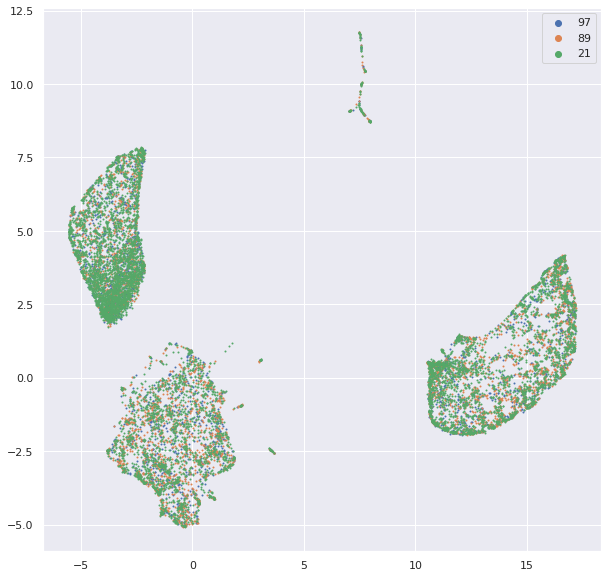

In [68]:
sns.set_theme(style='darkgrid')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for cluster_id in clusters_to_review:
    indexes = np.argwhere(labels==cluster_id)
    ax.scatter(u[indexes,0], u[indexes,1], label=cluster_id, s=1)
legend = ax.legend(frameon=True, markerscale=6)
plt.show()


In [ ]:
# Data Class with all h5, these contain the images.
data_dicts = dict()
data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

def cluster_set_images(frame, data_dicts, cluster_id, groupby, batches=1):
    indexes       = frame[frame[groupby]==cluster_id]['indexes'].values.tolist()
    original_sets = frame[frame[groupby]==cluster_id]['original_set'].values.tolist()
    combined      = list(zip(indexes, original_sets))
    random.shuffle(combined)
    combined_plot = sorted(combined[:100*batches])

    for batch in range(batches):
        images_cluster = list()
        for index, original_set in combined_plot[100*batch:100*(batch+1)]:
            images_cluster.append(data_dicts[original_set][int(index)]/255.)

        sns.set_theme(style='white')
        fig = plt.figure(figsize=(30, 6))
        fig.suptitle('Cluster %s' % (cluster_id), fontsize=18, fontweight='bold')
        grid = ImageGrid(fig, 111, nrows_ncols=(5, 20), axes_pad=0.1,)

        for ax, im in zip(grid, images_cluster):
            ax.imshow(im)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()
        sns.set_theme(style='darkgrid')

for cluster_id in clusters_to_review:
    print('Number of samples:', complete_merged[complete_merged[groupby]==cluster_id].shape[0])
    cluster_set_images(complete_merged, data_dicts, cluster_id, groupby, batches=10)
    print()
    print()
    print()

### Dump indexes to pickle

In [70]:
agreed_clusters    = [97, 89, 21]
clusters_to_remove = [104, 102, 99, 90, 86, 83, 73, 58] + agreed_clusters
clusters_to_remove

[104, 102, 99, 90, 86, 83, 73, 58, 97, 89, 21]

In [71]:
data_clusters = complete_merged[complete_merged[groupby].isin(clusters_to_remove)]
data_clusters

,0,1,2,3,4,5,6,7,8,9,...,labels,luad,original_set,os_event_data,os_event_ind,patterns,slides,tiles,complete_indexes,leiden_5.0
6,0.896011,1.816938,1.313362,-0.875785,1.246695,1.031004,1.387555,0.171284,-0.219639,-1.092502,...,0.0,1,train,14.728767123287671,0.0,TCGA-LUAD_not_reported,TCGA-67-4679-01Z-00-DX1,6_10.jpeg,6,89
13,-1.512191,-0.168796,0.650605,-1.054196,0.133850,-1.048738,0.336902,-0.302003,-0.428155,-0.271066,...,0.0,1,train,71.47397260273974,1.0,TCGA-LUAD_not_reported,TCGA-50-5045-01Z-00-DX2,20_2.jpeg,13,83
14,0.916470,1.891866,1.279870,-0.819510,1.243458,1.105528,1.419192,0.083991,-0.185301,-1.089111,...,0.0,1,train,14.728767123287671,0.0,TCGA-LUAD_not_reported,TCGA-67-4679-01Z-00-DX1,91_3.jpeg,14,89
17,0.840580,1.675874,1.100034,-0.732129,1.080528,0.944691,1.237014,0.019115,-0.152721,-0.959586,...,0.0,1,train,14.728767123287671,0.0,TCGA-LUAD_not_reported,TCGA-67-4679-01Z-00-DX1,9_12.jpeg,17,89
34,0.701682,1.484157,1.216270,-0.932841,1.099531,0.643373,1.221604,0.329863,-0.347593,-0.958022,...,0.0,1,train,14.728767123287671,0.0,TCGA-LUAD_not_reported,TCGA-67-4679-01Z-00-DX1,90_8.jpeg,34,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879218,-0.052702,-0.020330,-1.021587,-0.852262,-0.817049,0.847495,0.587725,-0.790601,-0.644210,0.561836,...,8.0,0,test,117.56712328767122,0.0,TCGA-LUSC_stage_iii,TCGA-18-3411-01Z-00-DX1,26_17.jpeg,882439,21
879268,-0.432401,-1.565568,-1.883207,0.788326,1.904535,1.619253,-1.427189,2.154028,1.218161,2.045572,...,8.0,0,test,23.572602739726037,0.0,TCGA-LUSC_stage_iii,TCGA-60-2724-01Z-00-DX1,46_44.jpeg,882489,99
879289,-0.430975,-1.581644,-1.908316,0.802436,1.923220,1.640754,-1.443917,2.179284,1.233145,2.069153,...,8.0,0,test,23.572602739726037,0.0,TCGA-LUSC_stage_iii,TCGA-60-2724-01Z-00-DX1,42_44.jpeg,882510,99
879293,-1.874793,-0.555979,0.811561,-0.975233,0.546114,-0.894571,-0.139269,-0.138604,0.099784,0.044889,...,8.0,0,test,23.572602739726037,0.0,TCGA-LUSC_stage_iii,TCGA-60-2724-01Z-00-DX1,60_43.jpeg,882514,86


In [76]:
# Indexes in the train/validation/test set split.
indexes_set = dict()
indexes_set['complete'] = data_clusters.complete_indexes.values.tolist()
for set_name in pd.unique(data_clusters['original_set'].values):
    indexes_set[set_name] = data_clusters[data_clusters['original_set']==set_name]['indexes'].astype(int).values.tolist()

for set_name in indexes_set:
    pickle_path = os.path.join(data_remove_path, '%s.pkl' % set_name)
    store_data(indexes_set[set_name], pickle_path)

### Additional dataset

In [83]:
if not additional_frame.shape[0] == additional_df.shape[0]:
    print('[Error] Expecting the same representations in the original H5 file and the cluster assignations.')
else:
    set_name = h5_additional_path.split('/hdf5_')[1].split('_he')[0]
    pickle_path = os.path.join(data_remove_path, '%s.pkl' % set_name)
    indexes_set = additional_df[additional_df[groupby].isin(clusters_to_remove)].index.astype(int).values.tolist()
    if len(indexes_set) > 0:
        store_data(indexes_set, pickle_path)



### Copy over the h5ad for reference, disk costly but necessary for backtracking

In [ ]:

adata_name  = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)
h5_path = os.path.join(adatas_path, adata_name) + '.h5ad'
shutil.copy2(h5_path, data_remove_path)